# Jason Huffman - MSDS 692 Project

## Summary of Project

This project is being performed as a requirement for the Regis University MSDS program.

The goal of this project is to execute an ongoing project from DrivenData.org with the intent of predicting whether individuals received the H1N1 and seasonal flu vaccines based on responses to the National 2009 H1N1 Flu Survey. This survey collected 35 variables on respondents including demographic information and opinions concerning H1N1 as well as information about whether the respondent received either the H1N1 or seasonal flu vaccine; the project can be found here: https://www.drivendata.org/competitions/66/flu-shot-learning/. While the data for this project is a bit dated, the current COVID-19 pandemic has made information from this survey relevant again. This survey could be used to identify populations that have historically been reluctant to receive flu type vaccines in order to better target advertising and information campaigns, which could lead to higher vaccination rates once a COVID-19 vaccine is released.

## Import Functions and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import uniform
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

training_set_features = pd.read_csv("https://s3.amazonaws.com/drivendata-prod/data/66/public/training_set_features.csv", index_col = 'respondent_id')
training_set_labels = pd.read_csv("https://s3.amazonaws.com/drivendata-prod/data/66/public/training_set_labels.csv", index_col = 'respondent_id')
test_set_features = pd.read_csv("https://s3.amazonaws.com/drivendata-prod/data/66/public/test_set_features.csv", index_col = 'respondent_id')
submission_format = pd.read_csv("https://s3.amazonaws.com/drivendata-prod/data/66/public/submission_format.csv", index_col = 'respondent_id')


## Exploratory Data Analysis

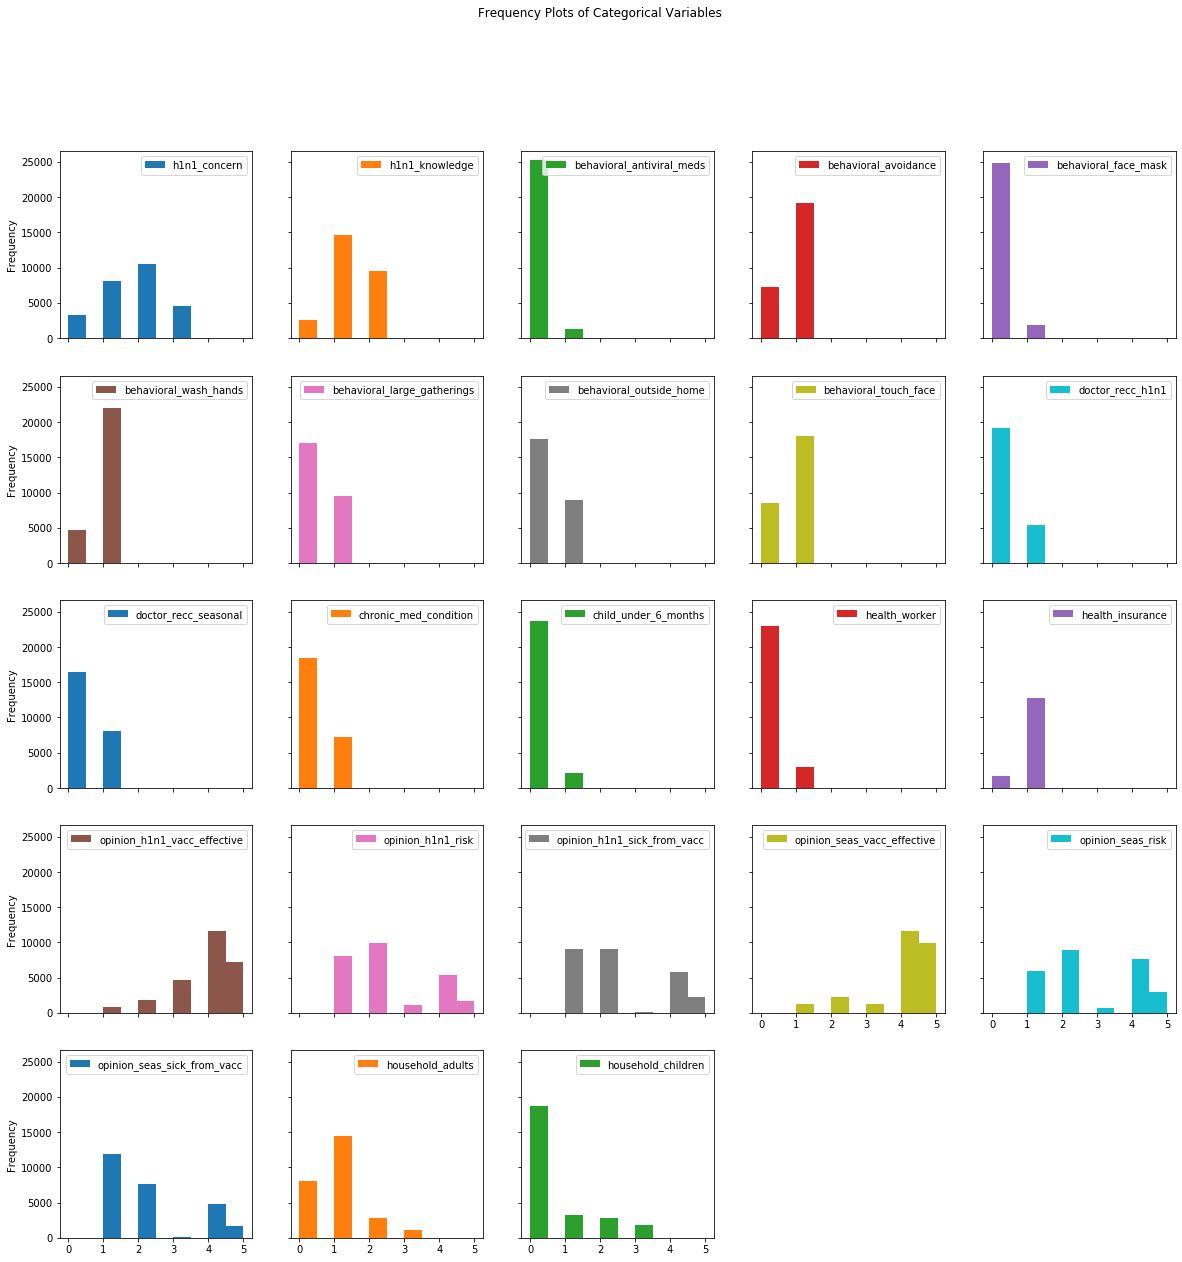

               h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
respondent_id                                                            
0                       1.0             0.0                        0.0   
1                       3.0             2.0                        0.0   
2                       1.0             1.0                        0.0   
3                       1.0             1.0                        0.0   
4                       2.0             1.0                        0.0   

               behavioral_avoidance  behavioral_face_mask  \
respondent_id                                               
0                               0.0                   0.0   
1                               1.0                   0.0   
2                               1.0                   0.0   
3                               1.0                   0.0   
4                               1.0                   0.0   

               behavioral_wash_hands  behavioral_larg

In [2]:
training_set_features.plot(kind = 'hist', subplots=True, layout=(5,5), figsize=(20,20), sharey=True, title = 'Frequency Plots of Categorical Variables')
plt.show()

print(training_set_features.head())
print(training_set_labels.head())
print(test_set_features.head())

print(training_set_features.info())
print(training_set_features.describe())

print(training_set_labels['h1n1_vaccine'].value_counts())
print(training_set_labels['seasonal_vaccine'].value_counts())


### Visualizations

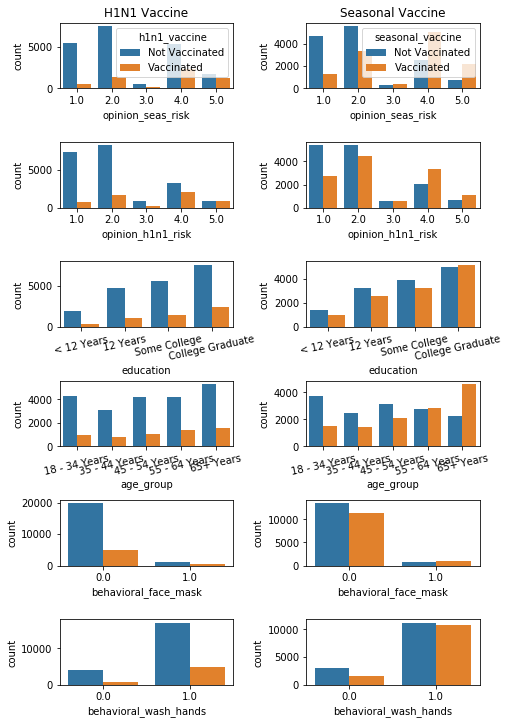

In [3]:
##Visualizations using Seaborn
joined_set = training_set_features.join(training_set_labels)
joined_set['h1n1_vaccine'] = joined_set['h1n1_vaccine'].replace(0, 'Not Vaccinated')
joined_set['h1n1_vaccine'] = joined_set['h1n1_vaccine'].replace(1, 'Vaccinated')
joined_set['seasonal_vaccine'] = joined_set['seasonal_vaccine'].replace(0, 'Not Vaccinated')
joined_set['seasonal_vaccine'] = joined_set['seasonal_vaccine'].replace(1, 'Vaccinated')
order_age = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
order_education = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
order_poverty = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']
f, axes = plt.subplots(6,2, sharex = False, sharey=False, figsize = (7,10))

sns.countplot( x = joined_set['opinion_seas_risk'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[0,0]).set_title('H1N1 Vaccine')
sns.countplot( x = joined_set['opinion_seas_risk'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[0,1]).set_title('Seasonal Vaccine')

sns.countplot( x = joined_set['opinion_h1n1_risk'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[1,0]).legend_.remove()
sns.countplot( x = joined_set['opinion_h1n1_risk'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[1,1]).legend_.remove()

sns.countplot( x = joined_set['education'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[2,0], order = order_education).set_xticklabels(order_education, rotation=12)
sns.countplot( x = joined_set['education'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[2,0], order = order_education).legend_.remove()
sns.countplot( x = joined_set['education'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[2,1], order = order_education).set_xticklabels(order_education, rotation = 12)
sns.countplot( x = joined_set['education'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[2,1], order = order_education).legend_.remove()

sns.countplot( x = joined_set['age_group'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[3, 0], order = order_age).set_xticklabels(order_age, rotation=12)
sns.countplot( x = joined_set['age_group'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[3, 0], order = order_age).legend_.remove()
sns.countplot( x = joined_set['age_group'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[3,1], order = order_age).set_xticklabels(order_age, rotation=12)
sns.countplot( x = joined_set['age_group'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[3,1], order = order_age).legend_.remove()

sns.countplot( x = joined_set['behavioral_face_mask'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[4,0]).legend_.remove()
sns.countplot( x = joined_set['behavioral_face_mask'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[4,1]).legend_.remove()

sns.countplot( x = joined_set['behavioral_wash_hands'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[5,0]).legend_.remove()
sns.countplot( x = joined_set['behavioral_wash_hands'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[5,1]).legend_.remove()

f.tight_layout(pad = 0.5)
plt.show()

## Pre-Process Data

### Impute missing values

The first step I took in pre-processing the data was to get rid of missing values in the dataset since many of the modeling techniques do not allow for missing values.

In [4]:
print(training_set_features.isnull().sum())

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

From the above output, we can see that there are many null values in the dataset that must be handled prior to modeling.  There are a number of ways to deal with missing values such as removing any row or column with missing values or imputing the values using a statistical technique.  I performed a combination of steps to handle the missing values.  First, since three of the columns are missing almost half the entries, I simply removed these columns entirely; these columns are health_insurance, employment_industry, and employment_occupation.  I then imputed the values of the remaining columns using the mean of the column to fill in the missing values.

In [5]:

training_set_features = training_set_features.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'])
test_set_features = test_set_features.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'])

cols = ["h1n1_concern", "h1n1_knowledge", "behavioral_antiviral_meds", "behavioral_avoidance",
        "behavioral_face_mask", "behavioral_wash_hands", "behavioral_large_gatherings", "behavioral_outside_home",
        "behavioral_touch_face", "doctor_recc_h1n1", "doctor_recc_seasonal", "chronic_med_condition",
        "child_under_6_months", "health_worker", "opinion_h1n1_vacc_effective", "opinion_h1n1_risk", 
        "opinion_h1n1_sick_from_vacc", "opinion_seas_vacc_effective", "opinion_seas_risk",
        "opinion_seas_sick_from_vacc", "age_group", "education", "race", "sex", "income_poverty",
        "marital_status", "rent_or_own", "employment_status", "hhs_geo_region", "census_msa", 
        "household_adults", "household_children"]
training_set_features[cols]=training_set_features[cols].fillna(training_set_features.mode().iloc[0])
test_set_features[cols]=test_set_features[cols].fillna(test_set_features.mode().iloc[0])


We can now see that there are no longer any null values in the dataset.

In [6]:
print(training_set_features.isnull().sum())

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_

### Encode Categorical Data

The prediction models can generally only handle numerical data; therefore, all of the categorical object variables must be numerically encoded.  In this case there are two different types of categorical data: ordinal and nominal.  Ordinal data is categorical data where the order matters, in this dataset the age_group, education, and income_poverty columns are all ordinal data since there is an order from low to high for this data.  The rest of the data is nominal mostly consisting of binary categories where the order does not matter.

For the ordinal data I am specifying the order the data should be in and using the factorize method to convert the object classes to numbers.  For the nominal data, I am one-hot encoding using Pandas get_dummies method.

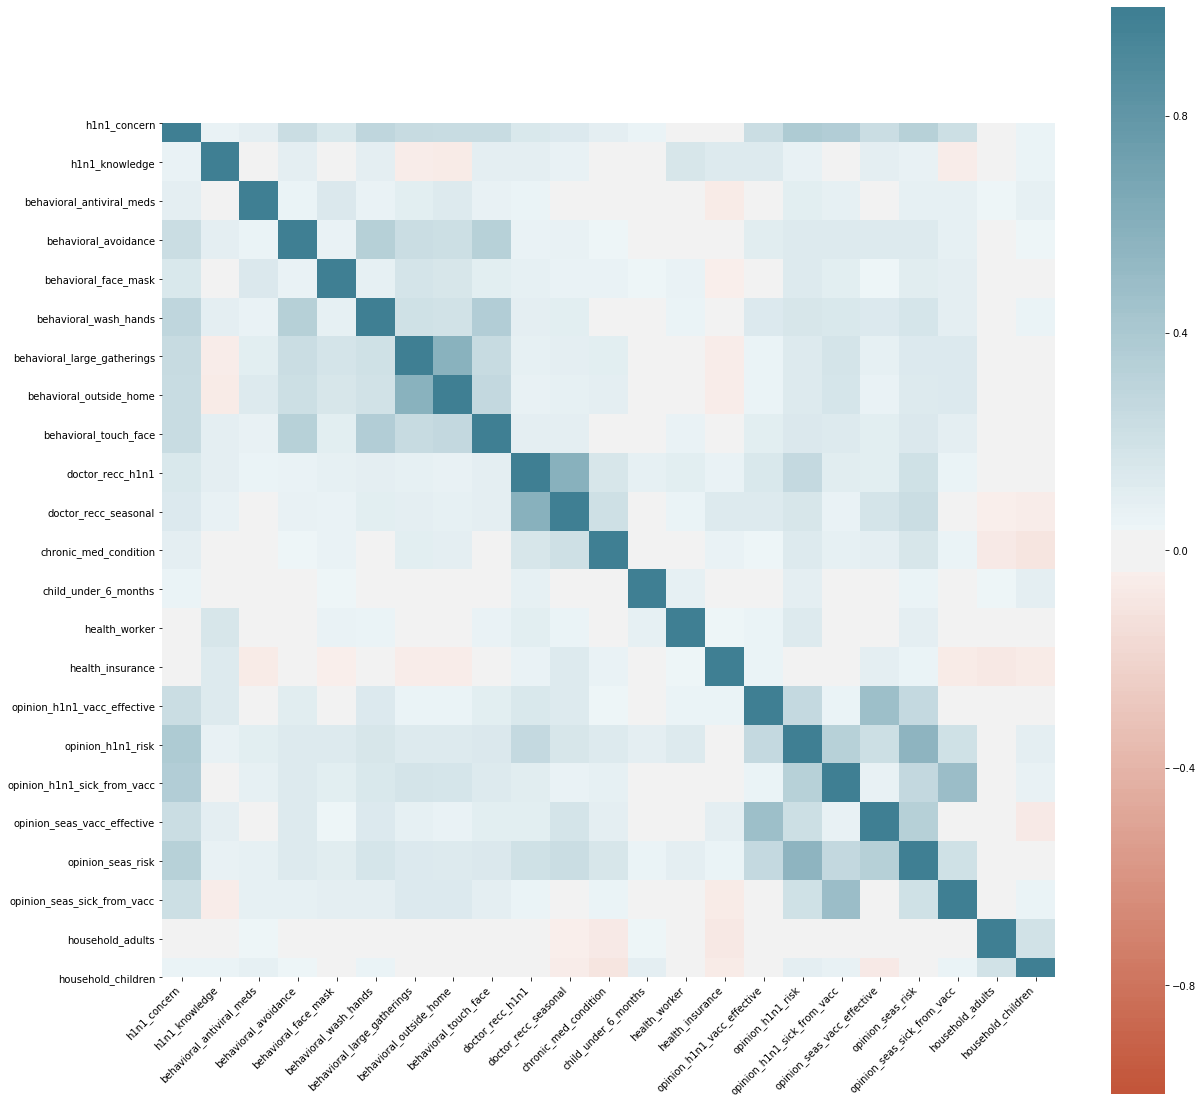

In [7]:
##Encode categorical data
# Ordinal data: age_group, education, income_poverty
# Nominal data: race, sex, marital_status, hhs_geo_region, census_msa

# Using pandas factorize method for ordinal data -- factorizing column data
categories = pd.Categorical(training_set_features['age_group'], categories=order_age, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
training_set_features['age_group'] = labels
categories = pd.Categorical(test_set_features['age_group'], categories=order_age, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
test_set_features['age_group'] = labels

categories = pd.Categorical(training_set_features['education'], categories=order_education, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
training_set_features['education'] = labels
categories = pd.Categorical(test_set_features['education'], categories=order_education, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
test_set_features['education'] = labels

categories = pd.Categorical(training_set_features['income_poverty'], categories=order_poverty, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
training_set_features['income_poverty'] = labels
categories = pd.Categorical(test_set_features['income_poverty'], categories=order_poverty, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
test_set_features['income_poverty'] = labels

###Plot correlations in training set
#print(joined_set.head())
fig, ax = plt.subplots(figsize=(20,20))
corr = joined_set.corr()
htmp = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
    annot=False
)
htmp.set_xticklabels(
    htmp.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

##One hot encode nominal categorical variables
training_set_features = pd.get_dummies(training_set_features, columns=['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'], 
                                       prefix = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'])
test_set_features = pd.get_dummies(test_set_features, columns=['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'], 
                                       prefix = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'])


### Scale Data

In [8]:
##Scale Data
scale = StandardScaler()
scaled_training_features =  scale.fit_transform(training_set_features)
scaled_test_features =  scale.fit_transform(test_set_features)

## Build Prediction Models

### Basic Prediction Models Using Sklearn

In [9]:
#Split into test and training set using 80% for training and 20% for testing so that we can keep test_set_labels data outside of the model
X_train, X_test, y_train, y_test = train_test_split(scaled_training_features, training_set_labels, test_size=0.2, random_state=0)

def fit_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    y_preds = pd.DataFrame(
        {
            "h1n1_vaccine": preds[0][:,1],
            "seasonal_vaccine": preds[1][:,1],
        },
        index = y_test.index
    )
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    model_name = namestr(model, globals())
    print('The ' + str(model_name)[2:-2] + ' ROC AUC score is ' + str(roc_auc_score(y_test, y_preds)))

Logistic_regression = MultiOutputClassifier(LogisticRegression())  
fit_model(Logistic_regression, X_train, y_train, X_test)

#KNN_model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=300))
#fit_model(KNN_model, X_train, y_train, X_test)

Random_forest = MultiOutputClassifier(RandomForestClassifier())
fit_model(Random_forest, X_train, y_train, X_test)

SGD_classifier = MultiOutputClassifier(SGDClassifier(loss="log"))
fit_model(SGD_classifier, X_train, y_train, X_test)

#SVC_model = MultiOutputClassifier(SVC(probability = True))
#fit_model(SVC_model, X_train, y_train, X_test)

#Extra_trees_classifier = MultiOutputClassifier(ExtraTreesClassifier())
#fit_model(Extra_trees_classifier, X_train, y_train, X_test)

The Logistic_regression ROC AUC score is 0.8347399891297653
The Random_forest ROC AUC score is 0.8333143695641141
The SGD_classifier ROC AUC score is 0.8225515225652571


### Parameter Optimization

I chose two of the best models from above on which to optimize the hyperparameters

#### Grid Search on Logistic Regression Model

Grid search iterates over every possible combination of parameters.  Since I am looking to optimize two different parameters with relatively few options for the logisic regression model, it will not take very long to perform a full grid search.

In [10]:
parameter_grid = {'estimator__C': [0.001,0.01,0.1,1,10,100],
            'estimator__penalty' : ['l1', 'l2']}

Log_regression_grid_optimized_classifier = GridSearchCV(
    estimator =  MultiOutputClassifier(LogisticRegression(solver='saga', max_iter=200)),
    param_grid = parameter_grid,
    scoring = 'roc_auc',
    n_jobs = 2,
    refit = True,
    cv = 5,
    return_train_score = True)

fit_model(Log_regression_grid_optimized_classifier, X_train, y_train, X_test)
cv_results_df = pd.DataFrame(Log_regression_grid_optimized_classifier.cv_results_)
best_row = cv_results_df[cv_results_df["rank_test_score"]==1]
print(best_row)

The Log_regression_grid_optimized_classifier ROC AUC score is 0.8349502836912611
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4       0.774526       0.07335         0.005386        0.001353   

  param_estimator__C param_estimator__penalty  \
4                0.1                       l1   

                                              params  split0_test_score  \
4  {'estimator__C': 0.1, 'estimator__penalty': 'l1'}           0.838644   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
4           0.840151           0.848554  ...         0.839144         0.00561   

   rank_test_score  split0_train_score  split1_train_score  \
4                1            0.841652            0.841112   

   split2_train_score  split3_train_score  split4_train_score  \
4            0.839077            0.842001            0.843424   

   mean_train_score  std_train_score  
4          0.841453         0.001413  

[1 rows x 22 columns]


#### Bayesian Search on Random Forest Model

The Random Forest model has a lot of hyperparameters that I chose to tune making a full grid search inefficient to implement.  I first used a random search method which randomly picks parameters for each iteration.  This method

In [ ]:
## Random Forest parameter optimization w/ Bayesian Method
n_estimators = [10, 50, 100, 200, 400, 600, 800, 1000, 2000]
max_depth = [10, 20, 30, 40, 60, 80, 100, 1000]
min_samples_split = [2, 5, 10, 20, 50]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'log2']
param_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__max_features': max_features}

random_forest_Bayes_optimized_classifier = BayesSearchCV(
    MultiOutputClassifier(RandomForestClassifier()),
    param_grid,
    n_iter = 50,
    scoring = 'roc_auc',
    n_jobs = 4,
    refit = True,
    cv = 3,
    random_state = 1,
    return_train_score = True)

fit_model(random_forest_Bayes_optimized_classifier, X_train, y_train, X_test)
print(random_forest_Bayes_optimized_classifier.best_estimator_)

## Formatting and Completion

### Train Model on Full Dataset

In [ ]:
# This is just a placeholder for now
#Logistic_regression = MultiOutputClassifier(LogisticRegression()) 
#Logistic_regression.fit(scaled_training_features, training_set_labels)
#preds = Logistic_regression.predict_proba(scaled_test_features)

### Format for Submission to Driven Data

In [ ]:
#Code copied from DrivenData to ensure correct format for submittal

# Save predictions to submission data frame
submission_format["h1n1_vaccine"] = preds[0][:, 1]
submission_format["seasonal_vaccine"] = preds[1][:, 1]

print(submission_format.head())
submission_format.to_csv('my_submission.csv', index= True)

## Final Thoughts

### Going Forward